In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py, numpy as np, pandas as pd
pd.options.display.float_format = '{:.6f}'.format

import matplotlib as mpl
import matplotlib.pyplot as plt
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)
import itertools
import pycbc.detector
from pycbc.inference import io

In [2]:
def tc_to_han(tc,ra,dec):
    '''
    Convert time from geocenter to Hanford given ra and dec
    '''
    det = pycbc.detector.Detector('H1')
    delay = det.time_delay_from_earth_center(ra, dec, tc)
    return tc + delay

In [3]:
def read_bf(dir221='posterior/221/',
            dir220='posterior/220/'):
    '''
    Load the Bayes factor from runs, this requires they have the same format
    '''
    df = pd.DataFrame(columns = ["t_hanford", "1024", "2048", "4096", "8192"])
    dt = np.linspace(-1.46, 1.47, 13)
    t0 = 1126259462.4085495
    ra = 1.95
    dec = -1.27
    for i in range(13):
        # initialization
        t_hanford = tc_to_han(t0 + dt[i]/1000, ra, dec)
        newrow = {'t_hanford': t_hanford}
        for sr in ['1024', '2048', '4096', '8192']:  
            fn = 'GW150914_SRATE' + str(sr) + '_' + str(i) + '.hdf'
            try:  
                with h5py.File(dir220 + fn,'r') as f0:
                    b220 = f0.attrs['log_evidence'] 
                    assert np.isclose(t0 + dt[i]/1000, f0.attrs['tref']+f0.attrs['toffset']) and \
                        np.isclose(ra, f0.attrs['ra']) and np.isclose(dec, f0.attrs['dec'])  
                with h5py.File(dir221 + fn,'r') as f1:
                    b221 = f1.attrs['log_evidence']
                    assert np.isclose(t0 + dt[i]/1000, f1.attrs['tref']+f1.attrs['toffset']) and \
                        np.isclose(ra, f1.attrs['ra']) and np.isclose(dec, f1.attrs['dec'])   
                newrow[sr] = b221 - b220
            except FileNotFoundError:
                newrow[sr] = np.nan
                continue 
        df.loc[len(df)] = newrow
    return df

In [4]:
df = read_bf()

In [5]:
df

,t_hanford,1024,2048,4096,8192
0,1126259462.421775,16.132586,8.953754,8.660374,5.479886
1,1126259462.422019,11.764833,5.793400,3.563843,5.222610
2,1126259462.422263,8.042854,5.042907,7.223115,6.440291
3,1126259462.422508,5.303183,4.037150,2.008756,0.135890
4,1126259462.422752,3.430622,2.406293,1.436409,2.888880
5,1126259462.422996,2.193593,2.401512,3.626968,3.282210
6,1126259462.423240,1.439483,2.542985,2.175730,2.281325
7,1126259462.423484,1.285085,1.667870,1.623367,1.903710
8,1126259462.423728,1.417343,2.236147,1.234253,1.790294
9,1126259462.423972,1.183438,1.529810,0.258538,-0.834552


Text(0.5, 1.0, 'GW150914 overtone')

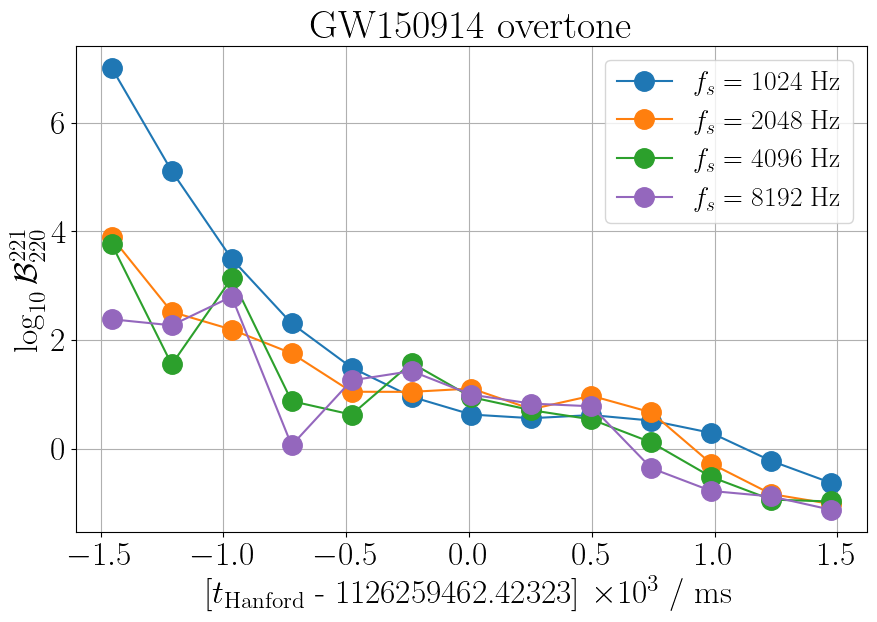

In [6]:
x = df['t_hanford']
tref = 1126259462.42323
relx = (x-tref)*1000 # convert to ms

# colors
color_cycle = [c['color'] for c in mpl.rcParams['axes.prop_cycle']]      
color_cycle.remove('#d62728') #remove red
colors = itertools.cycle(color_cycle)

# plot
for i,srate in enumerate(df.columns[1:]):
    color=next(colors)
    y = df[srate] / np.log(10)
    plt.plot(relx,y,'o-',alpha=1,label='$f_s='+str(srate)+'$ Hz',c=color)
    #plt.plot(relx,np.log(abs_sdbf[srate]),'^--',alpha=0.6,label='SD $f_s='+str(srate)+'$ Hz',c=color)

plt.legend()
plt.xlabel('[$t_\mathrm{Hanford}$ - '+str(tref)+']  $\\times 10^3$ / ms')
plt.ylabel('$\log_{10} \mathcal{B}^{221}_{220}$')
plt.title('GW150914 overtone')

In [7]:
df.to_csv('lnbayesfactor.csv',index=False)